# Flowers Image Classification using a linear model

We'll be using a creative-commons licensed
[flower photo dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers)
of 3670 images falling into 5 categories:
<pre>
'daisy', 'roses', 'dandelion', 'sunflowers', and 'tulips'
</pre>


## Enable GPU

This notebook and pretty much every other notebook in this repository
will run faster if you are using a GPU.
On Colab:
- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
- Navigate to https://console.cloud.google.com/ai-platform/notebooks
- Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [1]:
import torch
print(torch.__version__)
device_name = torch.cuda.current_device()
print(f'GPU: {device_name}')

2.5.1+cu121
GPU: 0


## Download and examin dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("batoolabbas91/flower-photos-by-the-tensorflow-team")

print("Path to dataset files:", path)

100%|██████████| 219M/219M [00:13<00:00, 17.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/batoolabbas91/flower-photos-by-the-tensorflow-team/versions/1


In [ ]:
! ls /root/.cache/kagglehub/datasets/batoolabbas91/flower-photos-by-the-tensorflow-team/versions/1/flower_photos/

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


In [3]:
import matplotlib.pylab as plt
import numpy as np
import cv2
from glob import glob
import os

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_img(filename, shape):
    img = cv2.imread(filename)
    img = img[..., ::-1]
    img = cv2.resize(img, shape)
    return img.astype(float) / 255

CLASS_NAMES = glob("/root/.cache/kagglehub/datasets/batoolabbas91/flower-photos-by-the-tensorflow-team/versions/1/flower_photos/*")
CLASS_NAMES = [os.path.basename(x) for x in CLASS_NAMES]
CLASS_NAMES = [x for x in CLASS_NAMES  if not '.' in x]
CLASS_NAMES

['roses', 'sunflowers', 'dandelion', 'tulips', 'daisy']

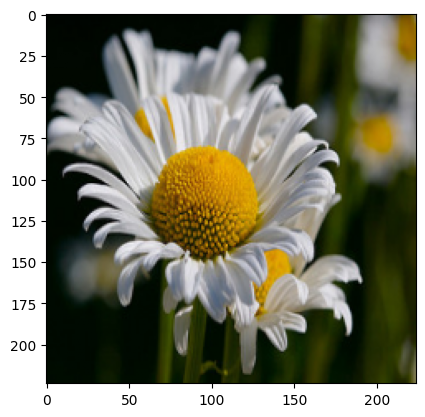

In [4]:
# Try reading and displaying one of the files
def show_image(filename):
  img = read_img(filename, [IMG_HEIGHT, IMG_WIDTH])
  plt.imshow(img);

show_image(
    "/root/.cache/kagglehub/datasets/batoolabbas91/flower-photos-by-the-tensorflow-team/versions/1/flower_photos/daisy/754296579_30a9ae018c_n.jpg")

/root/.cache/kagglehub/datasets/batoolabbas91/flower-photos-by-the-tensorflow-team/versions/1/flower_photos/tulips/17202535346_ab828e779b.jpg
/root/.cache/kagglehub/datasets/batoolabbas91/flower-photos-by-the-tensorflow-team/versions/1/flower_photos/tulips/17078576150_6f272ce73f_n.jpg
/root/.cache/kagglehub/datasets/batoolabbas91/flower-photos-by-the-tensorflow-team/versions/1/flower_photos/tulips/17282288501_e8738c9cfb_n.jpg
/root/.cache/kagglehub/datasets/batoolabbas91/flower-photos-by-the-tensorflow-team/versions/1/flower_photos/tulips/3511104954_54eace015c_n.jpg
/root/.cache/kagglehub/datasets/batoolabbas91/flower-photos-by-the-tensorflow-team/versions/1/flower_photos/tulips/5682463466_d3e641cb8b.jpg


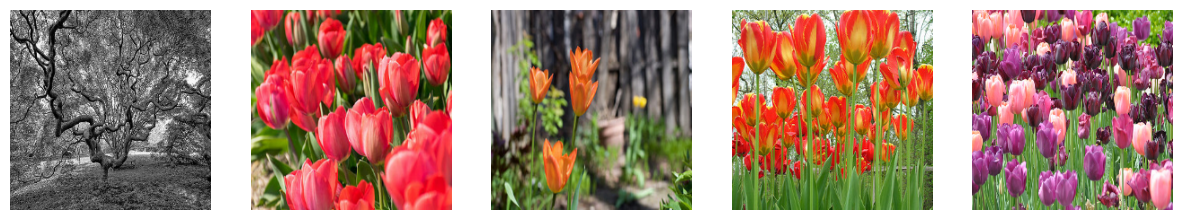

In [5]:
# notice that the file name has the flower type in it. Let's look at a few tulips
data_dir = "/root/.cache/kagglehub/datasets/batoolabbas91/flower-photos-by-the-tensorflow-team/versions/1/"
tulips = glob(os.path.join(data_dir, "flower_photos/tulips/*.jpg"))
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, filename in enumerate(tulips[:5]):
  print(filename)
  img = read_img(filename, [IMG_HEIGHT, IMG_WIDTH])
  ax[idx].imshow(img);
  ax[idx].axis('off')

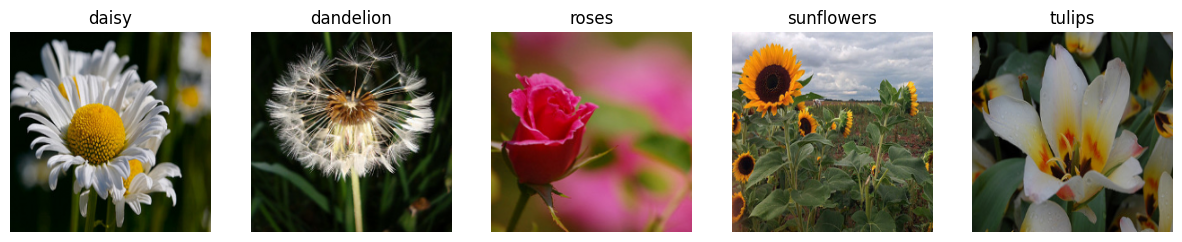

In [6]:
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, filename in enumerate([
  os.path.join(data_dir, "flower_photos/daisy/754296579_30a9ae018c_n.jpg"),
  os.path.join(data_dir, "flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg"),
  os.path.join(data_dir, "flower_photos/roses/7420699022_60fa574524_m.jpg"),
  os.path.join(data_dir, "flower_photos/sunflowers/21518663809_3d69f5b995_n.jpg"),
  os.path.join(data_dir, "flower_photos/tulips/8713398906_28e59a225a_n.jpg")
]):
  img = read_img(filename, [IMG_HEIGHT, IMG_WIDTH])
  ax[idx].imshow(img);
  ax[idx].set_title(filename.split('/')[-2])
  ax[idx].axis('off')

Let's split dataset to train / val with stratify by class

In [7]:
# split dataset to train / val
from sklearn.model_selection import train_test_split

X = glob(os.path.join(data_dir, "flower_photos/*/*.jpg"))
y = [filename.split('/')[-2] for filename in X]

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.10)

In [8]:
import pandas as pd

# save splits
train_df = pd.DataFrame({"path": X_train, "flower": y_train})
val_df = pd.DataFrame({"path": X_val, "flower": y_val})

train_df.to_csv("flowers_train.csv", index=False)
val_df.to_csv("flowers_val.csv", index=False)

Create torch dataset

In [9]:
from torch.utils.data import Dataset
from torchvision.io import read_image

class FlowersDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = read_img(img_path, [IMG_HEIGHT, IMG_WIDTH])
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [10]:
train_dataset = FlowersDataset("flowers_train.csv", data_dir)
val_dataset = FlowersDataset("flowers_val.csv", data_dir)

# decode_csv changed so that the label is the index into CLASS_NAMES array
def idx_label(label):
  label = np.argmax(np.equal(CLASS_NAMES, label))
  return label

train_dataset.img_labels["flower"] = train_dataset.img_labels["flower"].map(idx_label)
val_dataset.img_labels["flower"] = val_dataset.img_labels["flower"].map(idx_label)

img, label = train_dataset[0]

0


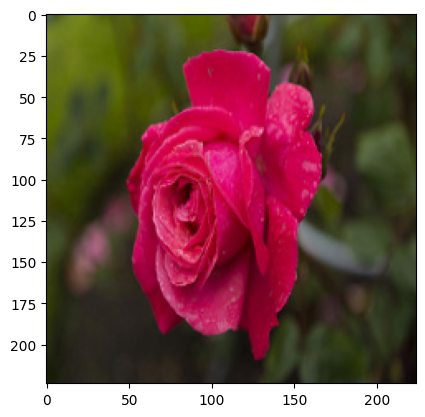

In [11]:
print(label)
plt.imshow(img)

In [12]:
# check if there are NaN-s

for i in range(10):
    img, label = train_dataset[i]
    avg = np.mean(img, axis=(0, 1)) # average pixel in the image
    print(label, avg)

0 [0.37850515 0.18496477 0.1689314 ]
4 [0.15347655 0.18102085 0.10231217]
2 [0.2123837  0.21415691 0.19145252]
2 [0.30239479 0.35916742 0.17458202]
0 [0.45738655 0.38433537 0.33173965]
1 [0.37037034 0.47901981 0.26525657]
2 [0.37959285 0.37566019 0.32997144]
2 [0.12989446 0.12989446 0.12989446]
3 [0.57946061 0.39353476 0.12313589]
4 [0.44652384 0.42508683 0.33405925]


This will take a while if we do all the images,
since there are about 800 images
per type of flower. Later in the book, we will look at
ways to speed up full passes through the data.

## A linear model

In [13]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=IMG_HEIGHT*IMG_WIDTH*IMG_CHANNELS,
                    out_features=5)
)

In [14]:
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=5, bias=True)
)

In [15]:
device = "cuda"
learning_rate = 1e-4

model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
## compute accuracy
def get_accuracy(inputs, target, batch_size):
    ''' Obtain accuracy for training round '''
    accuracy = torch.sum(inputs == target) / batch_size
    return accuracy.item()

In [17]:
# check accuracy
logits = torch.randn(3, 5, requires_grad=True)
s = torch.nn.Softmax(dim=1)
probs = s(logits)
inputs = torch.argmax(probs, dim=1)

targets = torch.empty(3, dtype=torch.long).random_(5)

print(f"pred probs: {probs}")
print(f"pred classes: {inputs}")
print(f"targets: {targets}")

acc = get_accuracy(inputs, targets, 3)

print(f"accuracy: {acc}")

pred probs: tensor([[0.0132, 0.0309, 0.1598, 0.0204, 0.7756],
        [0.1085, 0.1953, 0.1971, 0.4389, 0.0602],
        [0.1266, 0.1909, 0.1901, 0.2552, 0.2372]], grad_fn=<SoftmaxBackward0>)
pred classes: tensor([4, 3, 3])
targets: tensor([3, 2, 1])
accuracy: 0.0


In [18]:
from torchsummary import summary

summary(model, (1, 3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1               [-1, 150528]               0
            Linear-2                    [-1, 5]         752,645
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 1.15
Params size (MB): 2.87
Estimated Total Size (MB): 4.59
----------------------------------------------------------------


In [19]:
BATCH_SIZE = 10

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)

In [20]:
s = torch.nn.Softmax(dim=1)

In [21]:
# train loop
num_epochs = 10

history = {
    'train_loss': [],
    'val_loss': [],
    'train_accuracy': [],
    'val_accuracy': []
}

model = model.to(dtype=torch.float64)

for epoch in range(num_epochs):
    train_loss = 0.0
    train_accuracy = 0.0
    val_loss = 0.0
    val_accuracy = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):

        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_loss += loss.detach().item()

        probs = s(logits)
        inputs = torch.argmax(probs, dim=1)
        train_accuracy += get_accuracy(inputs, labels, BATCH_SIZE)

    history['train_loss'].append(train_loss / i)
    history['train_accuracy'].append(train_accuracy/i)
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_loss / i, train_accuracy / i))

    ## validation step
    model.eval()
    for i, (images, labels) in enumerate(valloader):

        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            ## forward + loss
            logits = model(images)
            loss = criterion(logits, labels)

            val_loss += loss.detach().item()

            probs = s(logits)
            inputs = torch.argmax(probs, dim=1)
            val_accuracy += get_accuracy(inputs, labels, BATCH_SIZE)

    history['val_loss'].append(val_loss / i)
    history['val_accuracy'].append(val_accuracy/i)

Epoch: 0 | Loss: 2.3288 | Train Accuracy: 0.36
Epoch: 1 | Loss: 2.2641 | Train Accuracy: 0.43
Epoch: 2 | Loss: 1.7629 | Train Accuracy: 0.49
Epoch: 3 | Loss: 1.6503 | Train Accuracy: 0.51
Epoch: 4 | Loss: 1.6206 | Train Accuracy: 0.54
Epoch: 5 | Loss: 1.4690 | Train Accuracy: 0.56
Epoch: 6 | Loss: 1.0413 | Train Accuracy: 0.65
Epoch: 7 | Loss: 1.2869 | Train Accuracy: 0.61
Epoch: 8 | Loss: 1.0226 | Train Accuracy: 0.66
Epoch: 9 | Loss: 1.2436 | Train Accuracy: 0.63


In [22]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
def training_plot(history):
    f, ax = plt.subplots(1, 2, figsize=(10,4))
    ax[0].plot(history['train_loss'])
    ax[0].plot(history['val_loss'], ls='dashed')
    ax[1].plot(history['train_accuracy'])
    ax[1].plot(history['val_accuracy'], ls='dashed')
    ax[0].set_xlabel("Epochs")
    ax[1].set_xlabel("Epochs")
    ax[0].legend(['train_loss', 'val_loss'], fontsize=15)
    ax[1].legend(['train_accuracy', 'val_accuracy'], fontsize=15)

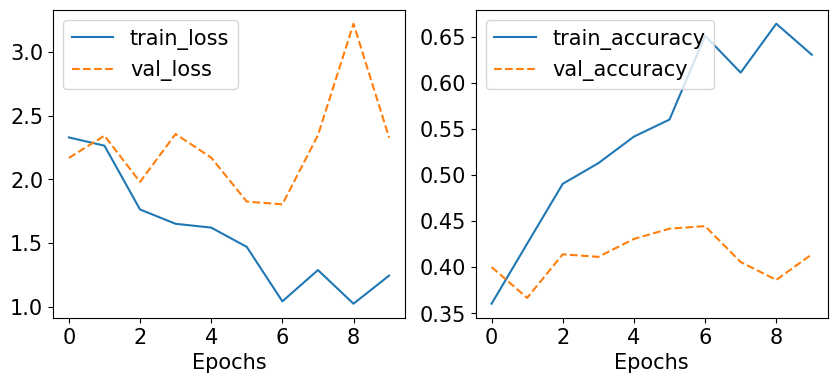

In [23]:
training_plot(history);

In [24]:
import numpy as np
import matplotlib.pylab as plt

In [26]:
# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(dataset):
    matplotlib.rcParams.update({'font.size': 14})
    f, ax = plt.subplots(3, 5, figsize=(25,15))
    for idx, (img, label) in enumerate(dataset):
        if idx > 14:
            break
        ax[idx//5, idx%5].imshow((img));
        batch_img = torch.unsqueeze(torch.Tensor(img), 0)
        batch_img = batch_img.to(torch.float64).to(device)
        batch_img
        with torch.no_grad():
            ## forward + loss
            logits = model(batch_img)
            probs = s(logits)
            preds = torch.argmax(probs, dim=1)
        label = CLASS_NAMES[label]
        pred_label = CLASS_NAMES[preds[0]]
        ax[idx//5, idx%5].set_title('{} -> {} ({:.2f})'.format(label, pred_label, torch.max(probs)))
        ax[idx//5, idx%5].axis('off')


plot_predictions(val_dataset)

Output hidden; open in https://colab.research.google.com to view.